# 1. Коллаборативная фильтрация

Как понять что пользователю **user** интересен фильм **item**?
1. Если понравился фильм похожий на item, то, вероятно, понравится item
2. Если не понравился фильм похожий на item, то, вероятно, не понравится item

Насколько **user-у** понравились фильмы, похожие на **item**.

Каждый товар можно предсавить как вектор оценок пользователей.

Тогда, для **оценки похожести** можно использовать следующие меры:
1. Косинусное расстояние, cosine similarity 
2. **Adjusted cosine similarity** (оказался наиболее эффективным)
3. Евклидово расстояние
4. Манхэтоновское расстояние
5. Коэффициент Жаккара

### Item-to-Item Collaborative Filtering 

$U_i$ - множество пользователей, оценивших фильм $i$. 

[Adjusted cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity): 

$ $ 

$$
u(i, j) = \frac{\sum_{u \in U_i \cap U_j} (r_{u, i} - \hat r_{u})(r_{u, j} - \hat r_{u})}
               {\sqrt{\sum_{u \in U_i \cap U_j} (r_{u, i} - \hat r_{u})^2} 
                \sqrt{\sum_{u \in U_i \cap U_j} (r_{u, j} - \hat r_{u})^2}}
$$

$S^{(i)}_{k}$- множество из k наиболее близких к item-у фильмов.

Чтобы вычислить похожесть между фильмами $i$ и $j$, нужно:
1. Выявить всех пользователей, которые оценили оба фильма, т.е. $U_i \cap U_j$
2. Нормализовать рейтинги фильмов $i$ и $j$.
3. Посчитать похожесть между векторами общих рейтингов $i$ и $j$.

Пользователю user, оценившему множество фильмов $I_{u}$, будем рекомендовать $N$ наиболее подходящих ему фильмов. 

Для этого:
* В качестве кандидата на попадание в топ возьмем фильмы

$$ C = \bigcup S^{(i)}_{k} \setminus I_{u} $$

* Для кандидатов $c \in C$ определим похожесть $c$ на историю пользователя $I_u$, как 

$$ w(c, I_u) = \sum_{i \in I} w_{cj}$$

* Вернем в качестве результата $N$ фильмов $c \in C$ с максималльной величиной $w(c, U_u)$.

Т.о. для пользователя на основе его истории хотим набрать кандадатов для ранжирования. 

**Пробежимся по всем фильмам, которые пользователь просмотрел, добавим к каждому из них похожие и вычтем множество просмотренных фильмов.**

In [1]:
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import os
import pandas as pd
import numpy as np
import joblib
import sys
import typing as tp

[This dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings.head(3)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0


In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [4]:
ratings.shape

(100836, 3)

In [5]:
# число пользователей 
np.unique(ratings['userId']).shape

(610,)

In [6]:
# число фильмов
np.unique(ratings['movieId']).shape

(9724,)

In [36]:
# рассмотрим только первые 1000 фильмов 
ratings = ratings[ratings['movieId'] <= 1000]
ratings.shape

(21667, 3)

In [40]:
# датасет для отображения результатов
movies = pd.read_csv('ml-latest-small/movies.csv')
movies = movies[['movieId', 'title']]
movies = movies[movies['movieId'] <= 1000]
movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
756,993,Infinity (1996)
757,994,Big Night (1996)
758,996,Last Man Standing (1996)
759,998,Set It Off (1996)


### Предобработка датасета 

In [9]:
def ids_encoder(ratings):
    
    users = sorted(ratings['userId'].unique())
    movies = sorted(ratings['movieId'].unique())
    
    # create users and items encoder
    user_encoder = LabelEncoder()
    movie_encoder = LabelEncoder()
    
    # fit users and items ids to the corresponding encoder
    user_encoder.fit(users)
    movie_encoder.fit(items)
    
    # encode user_Ids and item_Ids
    ratings['userId'] = user_encoder.transform(ratings['userId'].tolist())
    ratings['movieId'] = movie_encoder.transform(ratings['movieId'].tolist())    
    
    return ratings, user_encoder, item_encoder

# create the encoder 
ratings, user_encoder, item_encoder = ids_encoder(ratings)

In [34]:
ratings['movieId'].values

array([  0,   2,   5, ..., 705, 706, 741], dtype=int64)

### Реалиация алгоритма

#### Шаг 1. Вычислить похожести между фильмами

In [11]:
def normalize(ratings: pd.DataFrame) -> pd.DataFrame:
    # средний рейтинг по пользователю
    user_mean = pd.pivot_table(ratings, values='rating', index='userId', aggfunc='mean').rename(columns={'rating': 'mean_rating'})
    ratings = ratings.join(user_mean, on='userId')
    # нормальзация - среднее центрирование, чтобы учесть индивидуальные предпочтения пользователей
    # и сделать рейтинги более сравнимыми между собой
    ratings['norm_rating'] = ratings['rating'] - ratings['mean_rating']
    ratings.drop(columns = ['mean_rating'], inplace = True)
    return ratings

# def normalize(ratings: pd.DataFrame) -> pd.DataFrame:
#     user_mean = ratings[['userId', 'rating']].groupby('userId').mean('rating').rename(columns = {'rating' : 'mean_rating'})
#     ratings = ratings.join(user_mean, on = 'userId')
#     ratings['norm_rating'] = ratings['rating'] - ratings['mean_rating']
#     ratings.drop(columns = ['mean_rating'], inplace = True)
#     return ratings

def test_normalize():
    
    test_df = pd.DataFrame({
        'userId': [0, 0, 0, 1, 1],
        'itemId': [0, 1, 2, 1, 3],
        'rating': [2, 2, 5, 5, 5],
    })
    
    expected = pd.DataFrame({
        'userId': [0, 0, 0, 1, 1],
        'itemId': [0, 1, 2, 1, 3],
        'rating': [2, 2, 5, 5, 5],
        'norm_rating': [-1, -1, 2, 0, 0]
    })
    
    assert test_df.shape[0] == expected.shape[0]
    assert test_df.shape[1] + 1 == expected.shape[1]
    assert (normalize(test_df) == expected).all().all()

test_normalize()

In [12]:
norm_ratings = normalize(ratings)
norm_ratings.head()

,userId,movieId,rating,norm_rating
0,0,0,4.0,-0.22449
1,0,2,4.0,-0.22449
2,0,5,4.0,-0.22449
3,0,43,5.0,0.77551
4,0,46,5.0,0.77551


### Вычисление похожести фильмов

In [13]:
np_ratings = norm_ratings.to_numpy()

In [14]:
def cosine(x: np.array, y: np.array) -> float:
    if np.linalg.norm(x) == 0 or np.linalg.norm(y) == 0:
        return 0
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

from functools import lru_cache

@lru_cache(2000)  # для экономии времени и ресурсов
def ratings_for_item(i):
    return np_ratings[np_ratings[:, 1] == i]

def calculate_similarity_between_two(np_ratings: np.array, i: int, j: int) -> float:
    if i == j:
        return 1.0
    
    rating_i = ratings_for_item(i)  # все кто смотрел фильм i
    rating_j = ratings_for_item(j)  # все кто смотрел фильм j
    
    common_users = np.intersect1d(rating_i[:, 0], rating_j[:, 0])  # пересечение
    common_rating_i = rating_i[np.isin(rating_i[:, 0], common_users)] # кто из перечесения смотрел фильм i
    common_rating_j = rating_j[np.isin(rating_j[:, 0], common_users)] # кто из перечесения смотрел фильм j

    if len(common_users) > 0:
        assert sorted(common_rating_i[:, 0]) == sorted(common_rating_j[:, 0])
        x = common_rating_i[:, 3]
        y = common_rating_j[:, 3]
        return cosine(x, y)
    return 0

assert np.isclose(calculate_similarity_between_two(np_ratings, 0, 0), 1.0)   

calculate_similarity_between_two(np_ratings, 1, 2)

-0.007100819278384045

In [15]:
def ajusted_cosine(np_ratings: np.array, similarity_between_two) -> tp.Tuple[np.array, np.array]:
    """
    Высичляет ajusted сosine для всевозможных пар айтемов (i, j)
    
    Возвращает:
      1. массив размера |I|x|I|, в i-ой строке которого расположены в порядке убывания похожести i-го фильма
      2. массив размера |I|x|I|, в i-ой строке которого расположены Id фильмов 
                                                       в порядке убывания их похожестей с i-ым фильмом
    """
    # np_items = np.unique(np_ratings[:, 1]).size 
    np_items = int(np_ratings[:, 1].max()) + 1
    similarities = np.zeros(shape = (np_items, np_items))  # по умолчанию степень схожести будет 0
    np.fill_diagonal(similarities, 1)  # один и тот же фильм
    
    items = sorted(set(map(int, np_ratings[:, 1])))
    
    for i in tqdm(range(len(items))):
        for j in range(i + 1, len(items)):
            similarity = np.clip(similarity_between_two(np_ratings, items[i], items[j]), -1, 1)
            similarities[items[i], items[j]] = similarity
            similarities[items[j], items[i]] = similarity
            
    assert np.all(similarities.T == similarities) # Similarities_matrix should be symmetrical
    assert np.allclose(np.diag(similarities), 1.0) # Similarities of items wish thenselves should be 1
    
    # Id фильмов в порядке убывания схожести
    neighbors = np.flip(np.argsort(similarities), axis = 1)
    
    # Схожесть фильмов в порядке убывания
    similarities = np.flip(np.sort(similarities), axis = 1)
    
    return similarities, neighbors

similarities, neighbors = ajusted_cosine(np_ratings, calculate_similarity_between_two)

  0%|          | 0/761 [00:00<?, ?it/s]

In [16]:
similarities

array([[ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

In [17]:
neighbors

array([[  0, 600, 245, ..., 232, 634, 258],
       [640,  66, 353, ..., 241, 240, 269],
       [590, 374, 610, ..., 341, 323, 445],
       ...,
       [487, 616, 397, ..., 211, 109, 500],
       [760, 222, 565, ..., 225, 540, 503],
       [760, 662, 759, ..., 402, 751, 286]], dtype=int64)

Посмотрим на списки соседей, которые мы получили: 

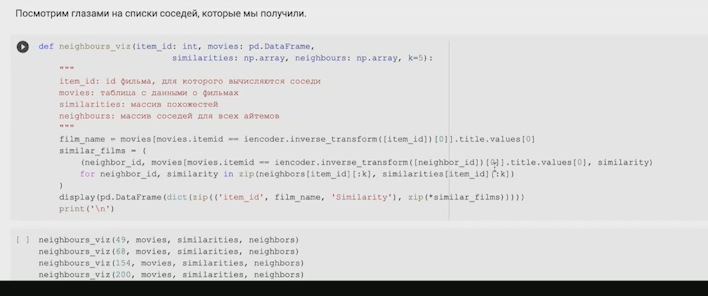

In [18]:
def neighbors_viz(item_id: int, movies: pd.DataFrame, similarities: np.array, neighbors: np.array, k = 5):
    """
    item_id: id фильма, для которого вычисляются соседи;
    movies: таблица с данными о фильмах;
    similarities: массив похожестей;
    neighbors: массив соседей для всех фильмов;
    """
    film_name = movies[movies.movieId == item_encoder.inverse_transform([item_id])[0]].title.values[0]
    similar_films = []
    for neighbor_id, similarity in zip(neighbors[item_id][:k], similarities[item_id][:k]):
        similar_film_name = movies[movies.movieId == item_encoder.inverse_transform([neighbor_id])[0]].title.values[0]
        similar_films.append((neighbor_id, similar_film_name, similarity))
        
    display(pd.DataFrame(dict(zip((f'Movie_Id = {item_id}', film_name, 'Similarity'), zip(*similar_films)))))
    print('\n')

In [19]:
neighbors_viz(49, movies, similarities, neighbors)

,Movie_Id = 49,"Big Green, The (1995)",Similarity
0,380,Color of Night (1994),1.0
1,313,"Flintstones, The (1994)",1.0
2,632,She's the One (1996),1.0
3,309,"Corrina, Corrina (1994)",1.0
4,382,"Cowboy Way, The (1994)",1.0


In [42]:
neighbors_viz(760, movies, similarities, neighbors)

,Movie_Id = 760,2 Days in the Valley (1996),Similarity
0,760,2 Days in the Valley (1996),1.0
1,662,Carpool (1996),1.0
2,759,Set It Off (1996),1.0
3,377,Clean Slate (1994),1.0
4,369,Blue Sky (1994),1.0


#### Шаг 2: Сформировать топ рекомедаций для пользователя
    
    1. Для каждого фильма из истории соберем множество из $k$ похожих фильмов
    2. Объединим полученные множества 
    3. Уберем из полученного множества те фильмы, которые уж просмотрены пользователем
    
    

In [57]:
def candidate_items(np_ratings: np.array, user_id: int, k = -1 ) -> tp.Tuple[np.array, np.array]:
    
    user_movie_ids = np_ratings[np_ratings[:, 0] == user_id]
    user_movie_ids = user_movie_ids[:, 1].astype('int')
    
    C = set()
    for movie_id in user_movie_ids:
        C.update(neighbors[movie_id, :k])
        
    C = list(C)
    candidates = np.setdiff1d(C, user_movie_ids, assume_unique = True) # пересечение 
    
    return user_movie_ids, candidates

In [81]:
user_id = 41
user_movie_ids, candidates = candidate_items(np_ratings, user_encoder.transform([user_id])[0])

print(f'Количество просмотренных фильмов пользователя {user_id}:', len(user_movie_ids))
print(f'Количество кандидатов для пользователя {user_id}:', len(candidates))

Количество просмотренных фильмов пользователя 41: 19
Количество кандидатов для пользователя 41: 742


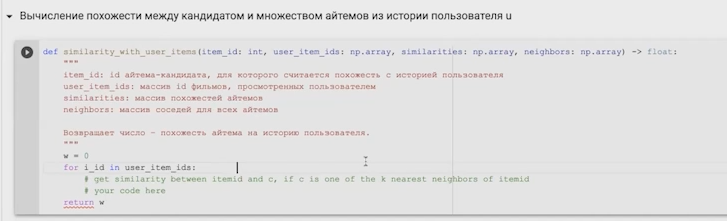

### Вычисление похожести между кандидатом и множеством фильмов из истории пользователя *user*

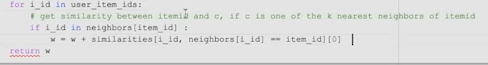

In [87]:
def similarity_with_user_items(movie_id: int, user_movie_ids: np.array, 
                               similarities: np.array, neighbors: np.array) -> float:
    """ Возвращает похожесть фильма на историю пользователя"""
    w = 0
    for i_id in user_movie_ids:
         w = w + similarities[i_id, neighbors[i_id] == movie_id][0]
    return w

In [88]:
similarity_with_user_items(5, user_movie_ids, similarities, neighbors)

5.477291750742862

### Ранжирование кандидатов по их похожестям на историю пользователя